### Performance Analysis of Random Forests + MultiMatch
This code will test performance for every participants where MW rate is between 25% - 75%.
So there will be 21 participants.
For each participant, I will also test this model for 10 times and calculate the average performance.

In [1]:
from random import shuffle
import numpy as np
import multimatch_gaze as mm
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from tqdm import tqdm

screen_size = [1920, 1080]
TDir = 45.0
TAmp = 100.0
TDur = 0.3

# training_num <= 5
training_num = 3
missing_data = ["22K", "25I", "29N", "39Y"]
too_focus = ["8I", "32S", "37T", "30Y", "27I", "7Y", "19M", "23H", "34I", "35S"]
too_MW = ["24K", "31M", "26K", "21H", "10H"]
black_list = set(missing_data + too_focus + too_MW)
print(len(black_list))

def read_scanpaths(input_dir, file_list):
    return [np.recfromcsv(os.path.join(input_dir, file), delimiter='\t', dtype=[('start_x', 'f8'), ('start_y', 'f8'), ('duration', 'f8')]) for file in file_list]

def create_pairs(scanpath_list1, scanpath_list2, label, TDir, TAmp, TDur):
    pairs = []
    for i in range(len(scanpath_list1)):
        for j in range(len(scanpath_list2)):
            similarity = mm.docomparison(scanpath_list1[i], scanpath_list2[j], screensize=screen_size, grouping=True, TDir=TDir, TAmp=TAmp, TDur=TDur)
            pairs.append((similarity, label))
    return pairs

def evaluate_parameters(TDir, TAmp, TDur, MW_training_list, Focus_training_list, MW_test_list, Focus_test_list):
    MW_MW_pair = create_pairs(MW_training_list, MW_training_list, 0, TDir, TAmp, TDur)
    Focus_Focus_pair = create_pairs(Focus_training_list, Focus_training_list, 0, TDir, TAmp, TDur)
    MW_Focus_pair = create_pairs(MW_training_list, Focus_training_list, 1, TDir, TAmp, TDur)

    training_data = MW_MW_pair + Focus_Focus_pair + MW_Focus_pair
    X_train = [pair[0] for pair in training_data]
    y_train = [pair[1] for pair in training_data]

    # Set the best hyperparameters directly
    best_params = {
        'bootstrap': True,
        'max_depth': None,
        'max_features': 'sqrt',
        'min_samples_leaf': 4,
        'min_samples_split': 2,
        'n_estimators': 100
    }

    best_clf = RandomForestClassifier(**best_params, random_state=42)
    best_clf.fit(X_train, y_train)

    test_pairs = create_pairs(MW_test_list, MW_test_list, 0, TDir, TAmp, TDur)
    test_pairs += create_pairs(Focus_test_list, Focus_test_list, 0, TDir, TAmp, TDur)
    test_pairs += create_pairs(MW_test_list, Focus_test_list, 1, TDir, TAmp, TDur)

    X_test = [pair[0] for pair in test_pairs]
    y_test = [pair[1] for pair in test_pairs]

    y_pred = best_clf.predict(X_test)
    
    # Performance Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, best_clf.predict_proba(X_test)[:, 1])
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, precision, recall, f1, roc_auc, cm, report

def main():
    input_dir = "../../Preprocess/FreeViewing/Scanpath/MultiMatch"
    name_list = [name for name in os.listdir(input_dir) if name not in black_list and not name.startswith(".")]
    
    overall_results = {
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "roc_auc": []
    }
    
    participant_results = {}

    for name in tqdm(name_list):
        participant_accuracies = []
        participant_precisions = []
        participant_recalls = []
        participant_f1s = []
        participant_roc_aucs = []

        for _ in range(10):
            participant_dir = os.path.join(input_dir, name)
            Focus_stim_list = [name for name in os.listdir(participant_dir) if name.endswith("Focus.tsv")]
            MW_stim_list = [name for name in os.listdir(participant_dir) if name.endswith("MW.tsv")]
            Focus_list = read_scanpaths(participant_dir, Focus_stim_list)
            MW_list = read_scanpaths(participant_dir, MW_stim_list)

            shuffle(Focus_stim_list)
            shuffle(MW_stim_list)
            
            MW_training_list = MW_list[:training_num]
            Focus_training_list = Focus_list[:training_num]
            
            MW_test_list = MW_list[training_num:]
            Focus_test_list = Focus_list[training_num:]
            
            # Ensure balanced test set
            min_test_samples = min(len(MW_test_list), len(Focus_test_list))
            MW_test_list = MW_test_list[:min_test_samples]
            Focus_test_list = Focus_test_list[:min_test_samples]

            accuracy, precision, recall, f1, roc_auc, cm, report = evaluate_parameters(TDir, TAmp, TDur, MW_training_list, Focus_training_list, MW_test_list, Focus_test_list)
            
            participant_accuracies.append(accuracy)
            participant_precisions.append(precision)
            participant_recalls.append(recall)
            participant_f1s.append(f1)
            participant_roc_aucs.append(roc_auc)

        participant_results[name] = {
            "accuracy": np.mean(participant_accuracies),
            "precision": np.mean(participant_precisions),
            "recall": np.mean(participant_recalls),
            "f1": np.mean(participant_f1s),
            "roc_auc": np.mean(participant_roc_aucs)
        }

        overall_results["accuracy"].append(np.mean(participant_accuracies))
        overall_results["precision"].append(np.mean(participant_precisions))
        overall_results["recall"].append(np.mean(participant_recalls))
        overall_results["f1"].append(np.mean(participant_f1s))
        overall_results["roc_auc"].append(np.mean(participant_roc_aucs))

    overall_averages = {metric: np.mean(scores) for metric, scores in overall_results.items()}
    
    print("Individual Participant Results:")
    for participant, metrics in participant_results.items():
        print(f"{participant}: {metrics}")
    
    print("Overall Average Performance:")
    print(overall_averages)

if __name__ == '__main__':
    main()

19


100%|██████████| 21/21 [02:19<00:00,  6.66s/it]

Individual Participant Results:
5N: {'accuracy': 0.7916666666666667, 'precision': 0.8, 'recall': 0.5, 'f1': 0.6153846153846153, 'roc_auc': 0.77734375}
28T: {'accuracy': 0.5648148148148148, 'precision': 0.4035087719298246, 'recall': 0.638888888888889, 'f1': 0.4946236559139784, 'roc_auc': 0.6377314814814816}
2U: {'accuracy': 0.5374149659863947, 'precision': 0.34426229508196726, 'recall': 0.42857142857142855, 'f1': 0.38181818181818183, 'roc_auc': 0.5733027905039567}
11S: {'accuracy': 0.6666666666666667, 'precision': 0.5, 'recall': 0.375, 'f1': 0.42857142857142855, 'roc_auc': 0.6640625}
18N: {'accuracy': 0.4583333333333333, 'precision': 0.3611111111111111, 'recall': 0.8125, 'f1': 0.5, 'roc_auc': 0.5711669921875}
4M: {'accuracy': 0.7291666666666667, 'precision': 0.5789473684210528, 'recall': 0.6875, 'f1': 0.6285714285714284, 'roc_auc': 0.796875}
33K: {'accuracy': 0.5625, 'precision': 0.4193548387096774, 'recall': 0.8125, 'f1': 0.5531914893617021, 'roc_auc': 0.59375}
3S: {'accuracy': 0.59670

19


100%|██████████| 21/21 [02:33<00:00,  7.30s/it]


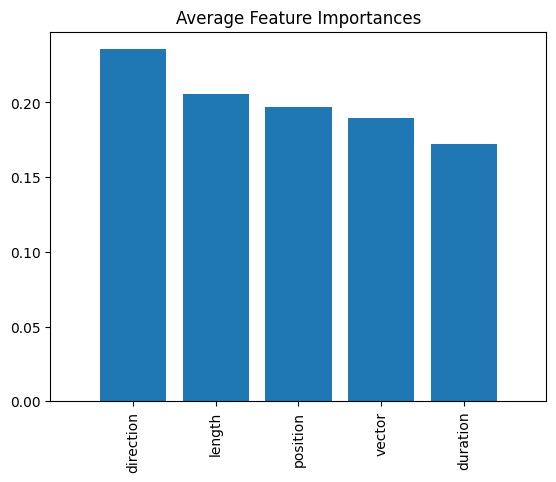

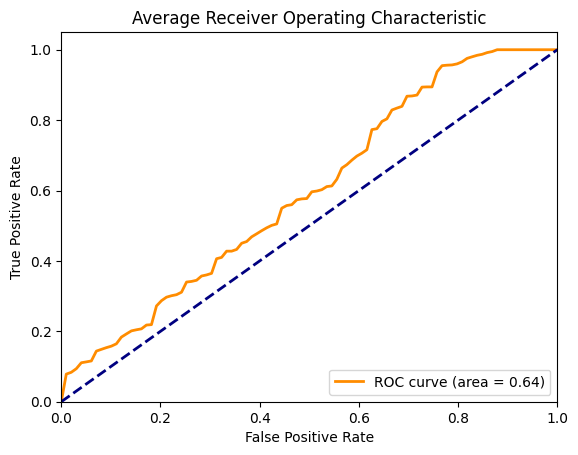

Individual Participant Results:
5N: {'accuracy': 0.7916666666666667, 'precision': 0.8, 'recall': 0.5, 'f1': 0.6153846153846153, 'roc_auc': 0.77734375}
28T: {'accuracy': 0.5648148148148148, 'precision': 0.4035087719298246, 'recall': 0.638888888888889, 'f1': 0.4946236559139784, 'roc_auc': 0.6377314814814816}
2U: {'accuracy': 0.5374149659863947, 'precision': 0.34426229508196726, 'recall': 0.42857142857142855, 'f1': 0.38181818181818183, 'roc_auc': 0.5733027905039567}
11S: {'accuracy': 0.6666666666666667, 'precision': 0.5, 'recall': 0.375, 'f1': 0.42857142857142855, 'roc_auc': 0.6640625}
18N: {'accuracy': 0.4583333333333333, 'precision': 0.3611111111111111, 'recall': 0.8125, 'f1': 0.5, 'roc_auc': 0.5711669921875}
4M: {'accuracy': 0.7291666666666667, 'precision': 0.5789473684210528, 'recall': 0.6875, 'f1': 0.6285714285714284, 'roc_auc': 0.796875}
33K: {'accuracy': 0.5625, 'precision': 0.4193548387096774, 'recall': 0.8125, 'f1': 0.5531914893617021, 'roc_auc': 0.59375}
3S: {'accuracy': 0.59670

In [5]:
import numpy as np
import multimatch_gaze as mm
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import shuffle
import pandas as pd

screen_size = [1920, 1080]
TDir = 45.0
TAmp = 100.0
TDur = 0.3

# training_num <= 5
training_num = 3
missing_data = ["22K", "25I", "29N", "39Y"]
too_focus = ["8I", "32S", "37T", "30Y", "27I", "7Y", "19M", "23H", "34I", "35S"]
too_MW = ["24K", "31M", "26K", "21H", "10H"]
black_list = set(missing_data + too_focus + too_MW)
print(len(black_list))

def read_scanpaths(input_dir, file_list):
    return [np.recfromcsv(os.path.join(input_dir, file), delimiter='\t', dtype=[('start_x', 'f8'), ('start_y', 'f8'), ('duration', 'f8')]) for file in file_list]

def create_pairs(scanpath_list1, scanpath_list2, label, TDir, TAmp, TDur):
    pairs = []
    for i in range(len(scanpath_list1)):
        for j in range(len(scanpath_list2)):
            similarity = mm.docomparison(scanpath_list1[i], scanpath_list2[j], screensize=screen_size, grouping=True, TDir=TDir, TAmp=TAmp, TDur=TDur)
            pairs.append((similarity, label))
    return pairs

def evaluate_parameters(TDir, TAmp, TDur, MW_training_list, Focus_training_list, MW_test_list, Focus_test_list):
    MW_MW_pair = create_pairs(MW_training_list, MW_training_list, 0, TDir, TAmp, TDur)
    Focus_Focus_pair = create_pairs(Focus_training_list, Focus_training_list, 0, TDir, TAmp, TDur)
    MW_Focus_pair = create_pairs(MW_training_list, Focus_training_list, 1, TDir, TAmp, TDur)

    training_data = MW_MW_pair + Focus_Focus_pair + MW_Focus_pair
    X_train = [pair[0] for pair in training_data]
    y_train = [pair[1] for pair in training_data]

    # Handle NaN values
    X_train = np.nan_to_num(X_train)

    # Set the best hyperparameters directly
    best_params = {
        'bootstrap': True,
        'max_depth': None,
        'max_features': 'sqrt',
        'min_samples_leaf': 4,
        'min_samples_split': 2,
        'n_estimators': 100
    }

    best_clf = RandomForestClassifier(**best_params, random_state=42)
    best_clf.fit(X_train, y_train)

    # Feature importances
    importances = best_clf.feature_importances_

    # Logistic Regression
    logistic_clf = LogisticRegression(random_state=42, max_iter=1000)
    logistic_clf.fit(X_train, y_train)

    test_pairs = create_pairs(MW_test_list, MW_test_list, 0, TDir, TAmp, TDur)
    test_pairs += create_pairs(Focus_test_list, Focus_test_list, 0, TDir, TAmp, TDur)
    test_pairs += create_pairs(MW_test_list, Focus_test_list, 1, TDir, TAmp, TDur)

    X_test = [pair[0] for pair in test_pairs]
    y_test = [pair[1] for pair in test_pairs]

    # Handle NaN values
    X_test = np.nan_to_num(X_test)

    y_pred = best_clf.predict(X_test)
    y_pred_proba = logistic_clf.predict_proba(X_test)[:, 1]

    # Performance Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, best_clf.predict_proba(X_test)[:, 1])
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    tpr_interp = np.interp(np.linspace(0, 1, 100), fpr, tpr)
    tpr_interp[0] = 0.0  # ensure the curve starts at 0
    tpr_interp[-1] = 1.0  # ensure the curve ends at 1

    return accuracy, precision, recall, f1, roc_auc, cm, report, importances, tpr_interp

def main():
    input_dir = "../../Preprocess/FreeViewing/Scanpath/MultiMatch"
    name_list = [name for name in os.listdir(input_dir) if name not in black_list and not name.startswith(".")]
    
    overall_results = {
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "roc_auc": [],
        "importances": [],
        "tpr": []
    }
    
    participant_results = {}

    for name in tqdm(name_list):
        participant_accuracies = []
        participant_precisions = []
        participant_recalls = []
        participant_f1s = []
        participant_roc_aucs = []
        participant_importances = []
        participant_tprs = []

        for _ in range(10):
            participant_dir = os.path.join(input_dir, name)
            Focus_stim_list = [name for name in os.listdir(participant_dir) if name.endswith("Focus.tsv")]
            MW_stim_list = [name for name in os.listdir(participant_dir) if name.endswith("MW.tsv")]
            Focus_list = read_scanpaths(participant_dir, Focus_stim_list)
            MW_list = read_scanpaths(participant_dir, MW_stim_list)

            shuffle(Focus_stim_list)
            shuffle(MW_stim_list)
            
            MW_training_list = MW_list[:training_num]
            Focus_training_list = Focus_list[:training_num]
            
            MW_test_list = MW_list[training_num:]
            Focus_test_list = Focus_list[training_num:]
            
            # Ensure balanced test set
            min_test_samples = min(len(MW_test_list), len(Focus_test_list))
            MW_test_list = MW_test_list[:min_test_samples]
            Focus_test_list = Focus_test_list[:min_test_samples]

            accuracy, precision, recall, f1, roc_auc, cm, report, importances, tpr_interp = evaluate_parameters(TDir, TAmp, TDur, MW_training_list, Focus_training_list, MW_test_list, Focus_test_list)
            
            participant_accuracies.append(accuracy)
            participant_precisions.append(precision)
            participant_recalls.append(recall)
            participant_f1s.append(f1)
            participant_roc_aucs.append(roc_auc)
            participant_importances.append(importances)
            participant_tprs.append(tpr_interp)

        participant_results[name] = {
            "accuracy": np.mean(participant_accuracies),
            "precision": np.mean(participant_precisions),
            "recall": np.mean(participant_recalls),
            "f1": np.mean(participant_f1s),
            "roc_auc": np.mean(participant_roc_aucs)
        }

        overall_results["accuracy"].append(np.mean(participant_accuracies))
        overall_results["precision"].append(np.mean(participant_precisions))
        overall_results["recall"].append(np.mean(participant_recalls))
        overall_results["f1"].append(np.mean(participant_f1s))
        overall_results["roc_auc"].append(np.mean(participant_roc_aucs))
        overall_results["importances"].append(np.mean(participant_importances, axis=0))
        overall_results["tpr"].append(np.mean(participant_tprs, axis=0))

    overall_averages = {metric: np.mean(scores) for metric, scores in overall_results.items() if metric != "importances" and metric != "tpr"}
    overall_importances = np.mean(overall_results["importances"], axis=0)
    overall_fpr = np.linspace(0, 1, 100)
    overall_tpr = np.mean(overall_results["tpr"], axis=0)
    
    # Plot average feature importances
    indices = np.argsort(overall_importances)[::-1]
    feature_names = ['vector', 'direction', 'length', 'position', 'duration']
    plt.figure()
    plt.title("Average Feature Importances")
    plt.bar(range(len(overall_importances)), overall_importances[indices], align="center")
    plt.xticks(range(len(overall_importances)), np.array(feature_names)[indices], rotation=90)
    plt.xlim([-1, len(overall_importances)])
    plt.show()

    # Plot average ROC curve
    plt.figure()
    plt.plot(overall_fpr, overall_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % overall_averages['roc_auc'])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    print("Individual Participant Results:")
    for participant, metrics in participant_results.items():
        print(f"{participant}: {metrics}")
    
    print("Overall Average Performance:")
    print(overall_averages)

if __name__ == '__main__':
    main()


In [6]:
import numpy as np
import multimatch_gaze as mm
import os
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import pandas as pd

# Parameters and settings
screen_size = [1920, 1080]
TDir = 45.0
TAmp = 100.0
TDur = 0.3

# Training number and blacklist settings
training_num = 3
missing_data = ["22K", "25I", "29N", "39Y"]
too_focus = ["8I", "32S", "37T", "30Y", "27I", "7Y", "19M", "23H", "34I", "35S"]
too_MW = ["24K", "31M", "26K", "21H", "10H"]
black_list = set(missing_data + too_focus + too_MW)

def read_scanpaths(input_dir, file_list):
    return [np.recfromcsv(os.path.join(input_dir, file), delimiter='\t', dtype=[('start_x', 'f8'), ('start_y', 'f8'), ('duration', 'f8')]) for file in file_list]

def create_pairs(scanpath_list1, scanpath_list2, label, TDir, TAmp, TDur):
    pairs = []
    for i in range(len(scanpath_list1)):
        for j in range(len(scanpath_list2)):
            similarity = mm.docomparison(scanpath_list1[i], scanpath_list2[j], screensize=screen_size, grouping=True, TDir=TDir, TAmp=TAmp, TDur=TDur)
            pairs.append((similarity, label))
    return pairs

def load_and_prepare_data(input_dir):
    name_list = [name for name in os.listdir(input_dir) if name not in black_list and not name.startswith(".")]
    
    all_pairs = []
    all_labels = []

    for name in name_list:
        participant_dir = os.path.join(input_dir, name)
        Focus_stim_list = [name for name in os.listdir(participant_dir) if name.endswith("Focus.tsv")]
        MW_stim_list = [name for name in os.listdir(participant_dir) if name.endswith("MW.tsv")]
        Focus_list = read_scanpaths(participant_dir, Focus_stim_list)
        MW_list = read_scanpaths(participant_dir, MW_stim_list)

        shuffle(Focus_stim_list)
        shuffle(MW_stim_list)
        
        MW_training_list = MW_list[:training_num]
        Focus_training_list = Focus_list[:training_num]
        
        MW_test_list = MW_list[training_num:]
        Focus_test_list = Focus_list[training_num:]
        
        # Ensure balanced test set
        min_test_samples = min(len(MW_test_list), len(Focus_test_list))
        MW_test_list = MW_test_list[:min_test_samples]
        Focus_test_list = Focus_test_list[:min_test_samples]

        pairs = create_pairs(MW_training_list, MW_training_list, 0, TDir, TAmp, TDur)
        pairs += create_pairs(Focus_training_list, Focus_training_list, 0, TDir, TAmp, TDur)
        pairs += create_pairs(MW_training_list, Focus_training_list, 1, TDir, TAmp, TDur)

        all_pairs.extend([pair[0] for pair in pairs])
        all_labels.extend([pair[1] for pair in pairs])
    
    return np.array(all_pairs), np.array(all_labels)

def logistic_regression_summary(X, y):
    # Handle missing and infinite values
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Normalize the predictor variables
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    X_normalized = pd.DataFrame(X_normalized, columns=['vector', 'direction', 'length', 'position', 'duration'])

    # Add a constant to the model (intercept)
    X_normalized = sm.add_constant(X_normalized)

    # Fit a logistic regression model
    logit_model = sm.Logit(y, X_normalized).fit()

    # Display the summary of the logistic regression model
    print(logit_model.summary())

def main():
    input_dir = "../../Preprocess/FreeViewing/Scanpath/MultiMatch"
    X, y = load_and_prepare_data(input_dir)
    logistic_regression_summary(X, y)

if __name__ == '__main__':
    main()


Optimization terminated successfully.
         Current function value: 0.564845
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  567
Model:                          Logit   Df Residuals:                      561
Method:                           MLE   Df Model:                            5
Date:                Tue, 11 Jun 2024   Pseudo R-squ.:                  0.1126
Time:                        16:02:09   Log-Likelihood:                -320.27
converged:                       True   LL-Null:                       -360.90
Covariance Type:            nonrobust   LLR p-value:                 4.545e-16
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9014      0.110     -8.162      0.000      -1.118      -0.685
vector         1.2989      1.